# 🍎🍌 Apple vs Banana Binary Classification Training

**Objective**: Train a CNN model to classify QuickDraw sketches of apples and bananas

**Dataset**: Fixed preprocessed Apple & Banana images from QuickDraw dataset
- Image size: 32x32 grayscale 
- Classes: 2 (Apple, Banana)
- Data format: NumPy arrays with proper coordinate scaling

**Approach**: Lightweight CNN optimized for binary classification of sketches

In [2]:
# Essential imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Deep Learning imports
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout, 
    BatchNormalization, GlobalAveragePooling2D
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (
    EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
)
from tensorflow.keras.utils import to_categorical

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("📦 Libraries imported successfully!")
print(f"🚀 TensorFlow version: {tf.__version__}")

📦 Libraries imported successfully!
🚀 TensorFlow version: 2.19.0


In [3]:
# Configuration
DATA_DIR = r'C:\Users\ACER\gitClones\QuickDrawGame\model_training\scripts\processed_data(Apple&Banana)_FIXED'
MODEL_SAVE_DIR = r'C:\Users\ACER\gitClones\QuickDrawGame\model_training\model'

# Training parameters
BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 0.001
VALIDATION_SPLIT = 0.2
TEST_SPLIT = 0.15

# Image parameters
IMG_HEIGHT = 32
IMG_WIDTH = 32
IMG_CHANNELS = 1  # Grayscale
NUM_CLASSES = 2   # Apple, Banana

print("⚙️  Configuration set!")
print(f"📁 Data directory: {DATA_DIR}")
print(f"💾 Model save directory: {MODEL_SAVE_DIR}")

⚙️  Configuration set!
📁 Data directory: C:\Users\ACER\gitClones\QuickDrawGame\model_training\scripts\processed_data(Apple&Banana)_FIXED
💾 Model save directory: C:\Users\ACER\gitClones\QuickDrawGame\model_training\model


In [4]:
def load_apple_banana_data(data_dir, max_files_per_class=None):
    """
    Load Apple and Banana image data from the processed dataset
    
    Args:
        data_dir: Directory containing the processed data
        max_files_per_class: Maximum number of files to load per class (for testing)
    
    Returns:
        X: Combined image data
        y: Combined labels (0=apple, 1=banana)
        class_names: List of class names
    """
    print("🔄 Loading Apple & Banana data...")
    
    # Get all image files
    apple_files = sorted(glob.glob(os.path.join(data_dir, 'apple_images_*.npy')))
    banana_files = sorted(glob.glob(os.path.join(data_dir, 'banana_images_*.npy')))
    
    # Limit files if specified (for testing)
    if max_files_per_class:
        apple_files = apple_files[:max_files_per_class]
        banana_files = banana_files[:max_files_per_class]
    
    print(f"🍎 Found {len(apple_files)} apple image files")
    print(f"🍌 Found {len(banana_files)} banana image files")
    
    # Load apple data
    apple_images = []
    for i, file in enumerate(apple_files):
        if i % 100 == 0:  # Progress indicator
            print(f"Loading apple files: {i+1}/{len(apple_files)}")
        data = np.load(file)
        apple_images.append(data)
    
    # Load banana data  
    banana_images = []
    for i, file in enumerate(banana_files):
        if i % 100 == 0:  # Progress indicator
            print(f"Loading banana files: {i+1}/{len(banana_files)}")
        data = np.load(file)
        banana_images.append(data)
    
    # Concatenate all images
    apple_data = np.concatenate(apple_images, axis=0) if apple_images else np.array([])
    banana_data = np.concatenate(banana_images, axis=0) if banana_images else np.array([])
    
    print(f"🍎 Total apple images: {len(apple_data)}")
    print(f"🍌 Total banana images: {len(banana_data)}")
    
    # Create combined dataset
    X = np.concatenate([apple_data, banana_data], axis=0)
    
    # Create labels (0=apple, 1=banana)
    apple_labels = np.zeros(len(apple_data), dtype=np.int32)
    banana_labels = np.ones(len(banana_data), dtype=np.int32)
    y = np.concatenate([apple_labels, banana_labels], axis=0)
    
    class_names = ['apple', 'banana']
    
    print(f"✅ Dataset loaded successfully!")
    print(f"📊 Total samples: {len(X)}")
    print(f"🏷️  Class distribution: Apple={len(apple_data)}, Banana={len(banana_data)}")
    
    return X, y, class_names

In [19]:
# Load the data - Use FULL dataset for better performance
# Remove max_files_per_class parameter to load full dataset
print("🔄 Loading FULL Apple & Banana dataset...")
X, y, class_names = load_apple_banana_data(DATA_DIR)  # Load full dataset

print(f"\n📏 Data shapes:")
print(f"   Images (X): {X.shape}")
print(f"   Labels (y): {y.shape}")
print(f"   Data type: {X.dtype}")
print(f"   Value range: {X.min()} - {X.max()}")

🔄 Loading FULL Apple & Banana dataset...
🔄 Loading Apple & Banana data...
🍎 Found 1448 apple image files
🍌 Found 3080 banana image files
Loading apple files: 1/1448
Loading apple files: 101/1448
Loading apple files: 101/1448
Loading apple files: 201/1448
Loading apple files: 201/1448
Loading apple files: 301/1448
Loading apple files: 301/1448
Loading apple files: 401/1448
Loading apple files: 401/1448
Loading apple files: 501/1448
Loading apple files: 501/1448
Loading apple files: 601/1448
Loading apple files: 601/1448
Loading apple files: 701/1448
Loading apple files: 701/1448
Loading apple files: 801/1448
Loading apple files: 801/1448
Loading apple files: 901/1448
Loading apple files: 901/1448
Loading apple files: 1001/1448
Loading apple files: 1001/1448
Loading apple files: 1101/1448
Loading apple files: 1101/1448
Loading apple files: 1201/1448
Loading apple files: 1201/1448
Loading apple files: 1301/1448
Loading apple files: 1301/1448
Loading apple files: 1401/1448
Loading apple fi

In [20]:
# Data preprocessing
def preprocess_data(X, y):
    """
    Preprocess the image data for training
    """
    print("🔧 Preprocessing data...")
    
    # Normalize pixel values to [0, 1]
    X = X.astype('float32') / 255.0
    
    # Reshape to add channel dimension
    X = X.reshape(-1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
    
    # Convert labels to categorical (one-hot encoding)
    y_categorical = to_categorical(y, NUM_CLASSES)
    
    print(f"✅ Preprocessing complete!")
    print(f"   Normalized range: {X.min():.3f} - {X.max():.3f}")
    print(f"   Final shape: {X.shape}")
    print(f"   Labels shape: {y_categorical.shape}")
    
    return X, y_categorical

# Apply preprocessing
X_processed, y_processed = preprocess_data(X, y)

🔧 Preprocessing data...
✅ Preprocessing complete!
✅ Preprocessing complete!
   Normalized range: 0.000 - 1.000
   Final shape: (452658, 32, 32, 1)
   Labels shape: (452658, 2)
   Normalized range: 0.000 - 1.000
   Final shape: (452658, 32, 32, 1)
   Labels shape: (452658, 2)


C:\Users\ACER\AppData\Local\Temp\ipykernel_11120\3084045585.py:27: UserWarning: Glyph 127820 (\N{BANANA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ACER\AppData\Local\Temp\ipykernel_11120\3084045585.py:27: UserWarning: Glyph 127822 (\N{RED APPLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


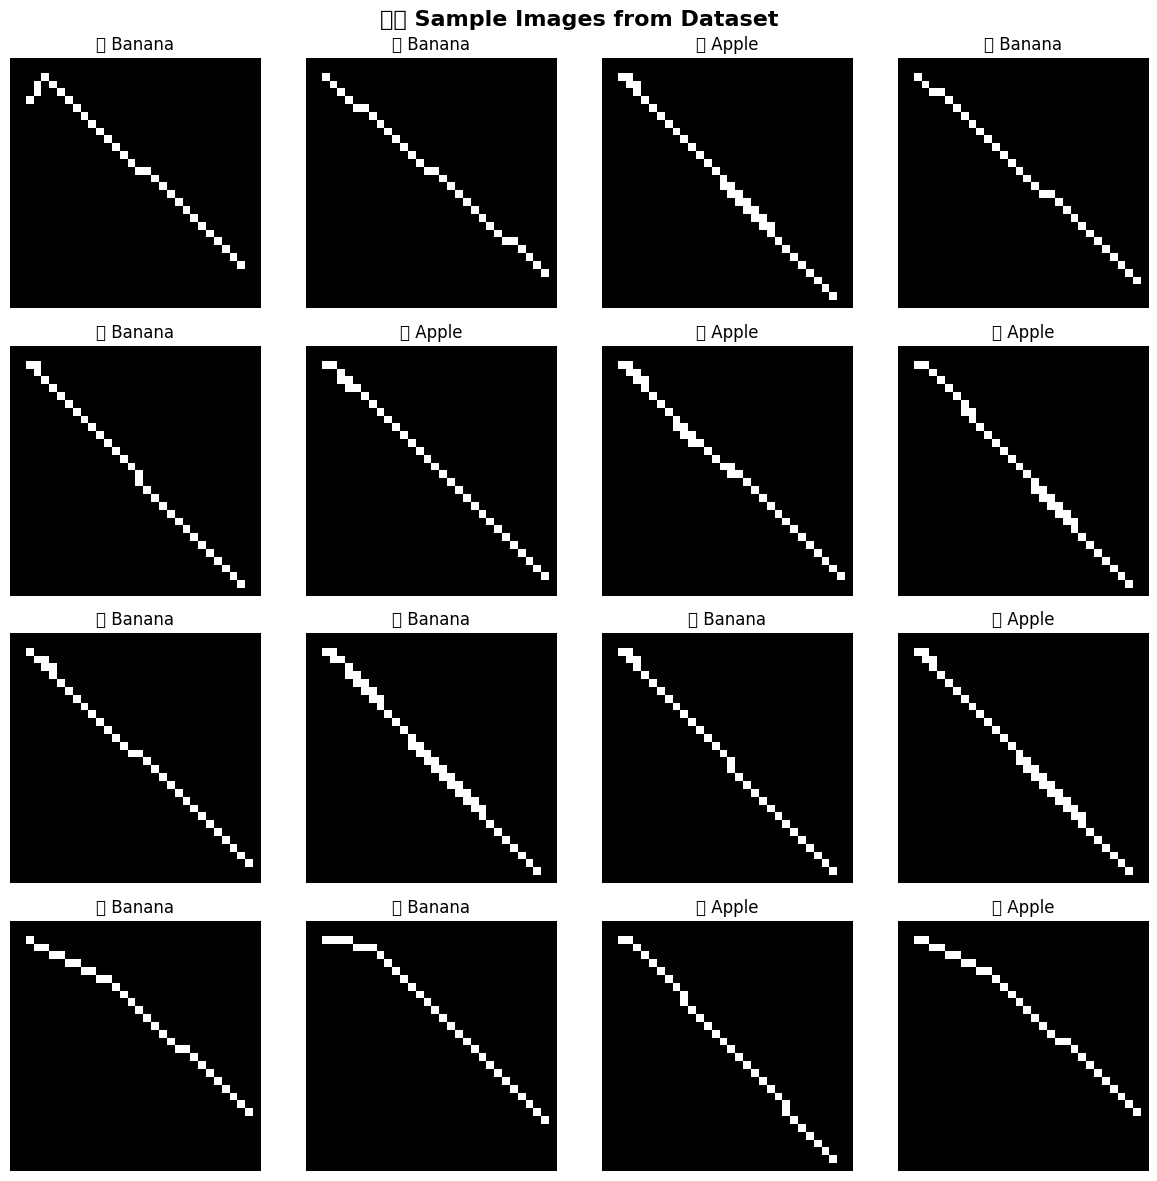

In [21]:
# Visualize sample images
def visualize_samples(X, y, class_names, num_samples=16):
    """
    Visualize random samples from the dataset
    """
    fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    fig.suptitle('🍎🍌 Sample Images from Dataset', fontsize=16, fontweight='bold')
    
    # Get random indices
    indices = np.random.choice(len(X), num_samples, replace=False)
    
    for i, idx in enumerate(indices):
        row = i // 4
        col = i % 4
        
        # Display image
        img = X[idx].squeeze()  # Remove channel dimension for display
        axes[row, col].imshow(img, cmap='gray_r')  # white background, black lines
        
        # Set title with class name
        class_idx = np.argmax(y[idx])
        class_name = class_names[class_idx]
        emoji = '🍎' if class_name == 'apple' else '🍌'
        axes[row, col].set_title(f'{emoji} {class_name.title()}')
        axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize samples
visualize_samples(X_processed, y_processed, class_names)

📊 DATASET ANALYSIS

🏷️  Class Distribution:
   🍎 Apple: 144,722 samples (32.0%)
   🍌 Banana: 307,936 samples (68.0%)

⚖️  Class Balance:
   ⚠️  Dataset is imbalanced (ratio: 2.13)
   💡 Consider using class weights or data augmentation

🖼️  Image Statistics:
   Total samples: 452,658
   Image shape: (32, 32, 1)
   Pixel value range: 0.000 - 1.000
   Pixel value range: 0.000 - 1.000
   Average pixel value: 0.966
   Average pixel value: 0.966


C:\Users\ACER\AppData\Local\Temp\ipykernel_11120\3790286001.py:55: UserWarning: Glyph 127822 (\N{RED APPLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ACER\AppData\Local\Temp\ipykernel_11120\3790286001.py:55: UserWarning: Glyph 127820 (\N{BANANA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


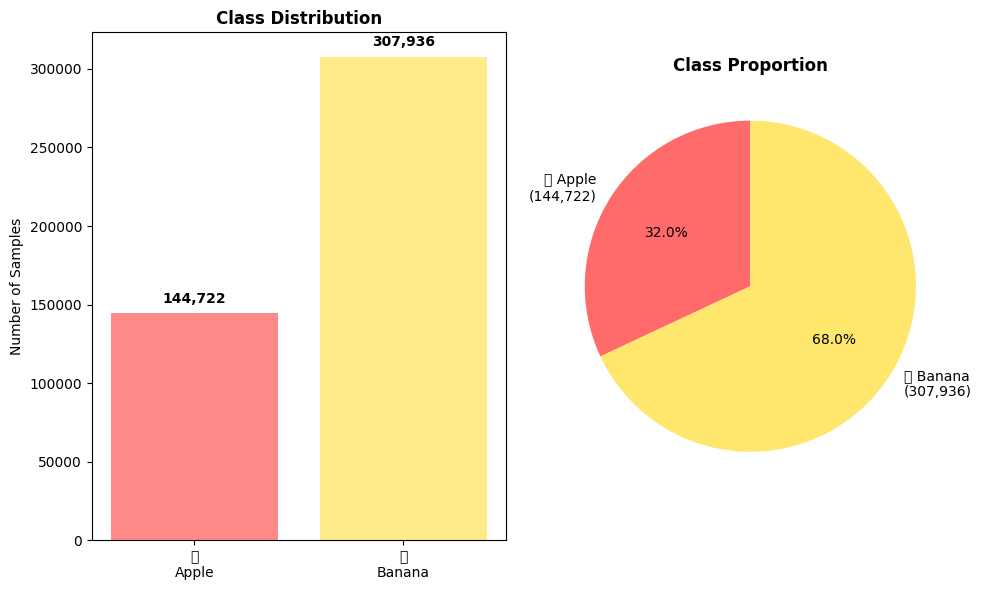

In [22]:
# Data analysis
def analyze_dataset(X, y, class_names):
    """
    Analyze the dataset distribution and characteristics
    """
    print("📊 DATASET ANALYSIS")
    print("=" * 50)
    
    # Class distribution
    class_counts = [np.sum(np.argmax(y, axis=1) == i) for i in range(NUM_CLASSES)]
    
    print("\n🏷️  Class Distribution:")
    for i, (name, count) in enumerate(zip(class_names, class_counts)):
        emoji = '🍎' if name == 'apple' else '🍌'
        percentage = (count / len(y)) * 100
        print(f"   {emoji} {name.title()}: {count:,} samples ({percentage:.1f}%)")
    
    # Check for class imbalance
    imbalance_ratio = max(class_counts) / min(class_counts)
    print(f"\n⚖️  Class Balance:")
    if imbalance_ratio > 1.5:
        print(f"   ⚠️  Dataset is imbalanced (ratio: {imbalance_ratio:.2f})")
        print(f"   💡 Consider using class weights or data augmentation")
    else:
        print(f"   ✅ Dataset is well balanced (ratio: {imbalance_ratio:.2f})")
    
    # Image statistics
    print(f"\n🖼️  Image Statistics:")
    print(f"   Total samples: {len(X):,}")
    print(f"   Image shape: {X.shape[1:]}")
    print(f"   Pixel value range: {X.min():.3f} - {X.max():.3f}")
    print(f"   Average pixel value: {X.mean():.3f}")
    
    # Plot class distribution
    plt.figure(figsize=(10, 6))
    
    plt.subplot(1, 2, 1)
    colors = ['#FF6B6B', '#FFE66D']  # Apple red, Banana yellow
    bars = plt.bar([f"🍎\n{class_names[0].title()}" , f"🍌\n{class_names[1].title()}"], 
                   class_counts, color=colors, alpha=0.8)
    plt.title('Class Distribution', fontweight='bold')
    plt.ylabel('Number of Samples')
    
    # Add value labels on bars
    for bar, count in zip(bars, class_counts):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + len(X)*0.01, 
                f'{count:,}', ha='center', va='bottom', fontweight='bold')
    
    plt.subplot(1, 2, 2)
    plt.pie(class_counts, labels=[f"🍎 {class_names[0].title()}\n({class_counts[0]:,})", 
                                  f"🍌 {class_names[1].title()}\n({class_counts[1]:,})"], 
            colors=colors, autopct='%1.1f%%', startangle=90)
    plt.title('Class Proportion', fontweight='bold')
    
    plt.tight_layout()
    plt.show()

# Analyze the dataset
analyze_dataset(X_processed, y_processed, class_names)

In [26]:
# Split the data
def split_data(X, y, test_split=0.15, val_split=0.2, random_state=42):
    """
    Split data into train, validation, and test sets
    """
    print("🔄 Splitting data into train/validation/test sets...")
    
    # First split: separate test set
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, test_size=test_split, random_state=random_state, 
        stratify=np.argmax(y, axis=1)  # Maintain class balance
    )
    
    # Second split: separate train and validation from remaining data
    val_size = val_split / (1 - test_split)  # Adjust validation size
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=val_size, random_state=random_state,
        stratify=np.argmax(y_temp, axis=1)  # Maintain class balance
    )
    
    print(f"✅ Data split complete!")
    print(f"   🚂 Training set:   {X_train.shape[0]:,} samples ({(len(X_train)/len(X))*100:.1f}%)")
    print(f"   ✅ Validation set: {X_val.shape[0]:,} samples ({(len(X_val)/len(X))*100:.1f}%)")
    print(f"   🧪 Test set:       {X_test.shape[0]:,} samples ({(len(X_test)/len(X))*100:.1f}%)")
    
    return X_train, X_val, X_test, y_train, y_val, y_test

# Split the data
X_train, X_val, X_test, y_train, y_val, y_test = split_data(
    X_processed, y_processed, TEST_SPLIT, VALIDATION_SPLIT
)

🔄 Splitting data into train/validation/test sets...
✅ Data split complete!
   🚂 Training set:   294,227 samples (65.0%)
   ✅ Validation set: 90,532 samples (20.0%)
   🧪 Test set:       67,899 samples (15.0%)
✅ Data split complete!
   🚂 Training set:   294,227 samples (65.0%)
   ✅ Validation set: 90,532 samples (20.0%)
   🧪 Test set:       67,899 samples (15.0%)


In [27]:
# Build the CNN model
def create_cnn_model(input_shape=(32, 32, 1), num_classes=2):
    """
    Create a CNN model optimized for 32x32 grayscale sketch classification
    
    Architecture designed for QuickDraw sketches:
    - Lightweight but effective for binary classification
    - BatchNormalization for stable training
    - Dropout for regularization
    - Global Average Pooling to reduce parameters
    """
    model = Sequential([
        # First Conv Block
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, name='conv1'),
        BatchNormalization(name='bn1'),
        MaxPooling2D((2, 2), name='pool1'),
        
        # Second Conv Block  
        Conv2D(64, (3, 3), activation='relu', name='conv2'),
        BatchNormalization(name='bn2'),
        MaxPooling2D((2, 2), name='pool2'),
        
        # Third Conv Block
        Conv2D(128, (3, 3), activation='relu', name='conv3'),
        BatchNormalization(name='bn3'),
        
        # Global Average Pooling instead of Flatten (reduces parameters)
        GlobalAveragePooling2D(name='global_avg_pool'),
        
        # Dense layers
        Dense(64, activation='relu', name='dense1'),
        Dropout(0.5, name='dropout1'),
        
        # Output layer
        Dense(num_classes, activation='softmax', name='output')
    ], name='AppleBananaCNN')
    
    return model

# Create the model
model = create_cnn_model(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), 
                        num_classes=NUM_CLASSES)

# Display model architecture
print("🏗️  MODEL ARCHITECTURE")
print("=" * 50)
model.summary()

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\n✅ Model compiled successfully!")
print(f"   Optimizer: Adam (lr={LEARNING_RATE})")
print(f"   Loss: categorical_crossentropy")
print(f"   Metrics: accuracy")

🏗️  MODEL ARCHITECTURE


c:\Users\ACER\gitClones\CV_ENV\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "AppleBananaCNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                  │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1 (BatchNormalization)        │ (None, 30, 30, 32)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2 (BatchNormalization)        │ (None, 13, 13, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn3 (BatchNormalization)        │ (None, 4, 4, 128)      │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_pool                 │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (Dropout)              │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,954 (398.26 KB)

 Trainable params: 101,506 (396.51 KB)

 Non-trainable params: 448 (1.75 KB)


✅ Model compiled successfully!
   Optimizer: Adam (lr=0.001)
   Loss: categorical_crossentropy
   Metrics: accuracy


In [28]:
# Setup training callbacks
def setup_callbacks(model_save_path):
    """
    Setup training callbacks for better training control
    """
    callbacks = [
        # Early stopping to prevent overfitting
        EarlyStopping(
            monitor='val_accuracy',
            patience=10,
            restore_best_weights=True,
            verbose=1,
            mode='max'
        ),
        
        # Reduce learning rate on plateau
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-7,
            verbose=1
        ),
        
        # Save best model
        ModelCheckpoint(
            model_save_path,
            monitor='val_accuracy',
            save_best_only=True,
            save_weights_only=False,
            verbose=1,
            mode='max'
        )
    ]
    
    return callbacks

# Setup callbacks
model_save_path = os.path.join(MODEL_SAVE_DIR, 'best_apple_banana_model.h5')
callbacks = setup_callbacks(model_save_path)

print("🔧 Training callbacks configured:")
print(f"   ✅ Early Stopping (patience=10)")
print(f"   📉 Learning Rate Reduction (patience=5)")
print(f"   💾 Model Checkpoint: {model_save_path}")

🔧 Training callbacks configured:
   ✅ Early Stopping (patience=10)
   📉 Learning Rate Reduction (patience=5)
   💾 Model Checkpoint: C:\Users\ACER\gitClones\QuickDrawGame\model_training\model\best_apple_banana_model.h5


In [29]:
# Train the model
print("🚀 Starting model training...")
print(f"📊 Training samples: {len(X_train):,}")
print(f"📊 Validation samples: {len(X_val):,}")
print(f"⚙️  Batch size: {BATCH_SIZE}")
print(f"🔄 Max epochs: {EPOCHS}")
print("=" * 60)

# Start training
history = model.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)

print("\n🎉 Training completed!")

🚀 Starting model training...
📊 Training samples: 294,227
📊 Validation samples: 90,532
⚙️  Batch size: 32
🔄 Max epochs: 50
Epoch 1/50
Epoch 1/50
9195/9195 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6926 - loss: 0.5752
Epoch 1: val_accuracy improved from -inf to 0.70564, saving model to C:\Users\ACER\gitClones\QuickDrawGame\model_training\model\best_apple_banana_model.h5

Epoch 1: val_accuracy improved from -inf to 0.70564, saving model to C:\Users\ACER\gitClones\QuickDrawGame\model_training\model\best_apple_banana_model.h5


9195/9195 ━━━━━━━━━━━━━━━━━━━━ 151s 16ms/step - accuracy: 0.6926 - loss: 0.5752 - val_accuracy: 0.7056 - val_loss: 0.5528 - learning_rate: 0.0010
Epoch 2/50
Epoch 2/50
9193/9195 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7078 - loss: 0.5547
Epoch 2: val_accuracy did not improve from 0.70564
9195/9195 ━━━━━━━━━━━━━━━━━━━━ 162s 18ms/step - accuracy: 0.7078 - loss: 0.5547 - val_accuracy: 0.6879 - val_loss: 0.5952 - learning_rate: 0.0010
Epoch 3/50

Epoch 2: val_accuracy did not improve from 0.70564
9195/9195 ━━━━━━━━━━━━━━━━━━━━ 162s 18ms/step - accuracy: 0.7078 - loss: 0.5547 - val_accuracy: 0.6879 - val_loss: 0.5952 - learning_rate: 0.0010
Epoch 3/50
9193/9195 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7121 - loss: 0.5491
Epoch 3: val_accuracy improved from 0.70564 to 0.71588, saving model to C:\Users\ACER\gitClones\QuickDrawGame\model_training\model\best_apple_banana_model.h5

Epoch 3: val_accuracy improved from 0.70564 to 0.71588, saving model to C:\Users\ACER\gitClones\Quic

9195/9195 ━━━━━━━━━━━━━━━━━━━━ 149s 16ms/step - accuracy: 0.7121 - loss: 0.5491 - val_accuracy: 0.7159 - val_loss: 0.5406 - learning_rate: 0.0010
Epoch 4/50
Epoch 4/50
9192/9195 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7133 - loss: 0.5457
Epoch 4: val_accuracy improved from 0.71588 to 0.71781, saving model to C:\Users\ACER\gitClones\QuickDrawGame\model_training\model\best_apple_banana_model.h5

Epoch 4: val_accuracy improved from 0.71588 to 0.71781, saving model to C:\Users\ACER\gitClones\QuickDrawGame\model_training\model\best_apple_banana_model.h5


9195/9195 ━━━━━━━━━━━━━━━━━━━━ 139s 15ms/step - accuracy: 0.7133 - loss: 0.5457 - val_accuracy: 0.7178 - val_loss: 0.5392 - learning_rate: 0.0010
Epoch 5/50
Epoch 5/50
9192/9195 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7161 - loss: 0.5432
Epoch 5: val_accuracy did not improve from 0.71781
9195/9195 ━━━━━━━━━━━━━━━━━━━━ 142s 15ms/step - accuracy: 0.7161 - loss: 0.5432 - val_accuracy: 0.7160 - val_loss: 0.5428 - learning_rate: 0.0010
Epoch 6/50

Epoch 5: val_accuracy did not improve from 0.71781
9195/9195 ━━━━━━━━━━━━━━━━━━━━ 142s 15ms/step - accuracy: 0.7161 - loss: 0.5432 - val_accuracy: 0.7160 - val_loss: 0.5428 - learning_rate: 0.0010
Epoch 6/50
9192/9195 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7167 - loss: 0.5410
Epoch 6: val_accuracy did not improve from 0.71781
9195/9195 ━━━━━━━━━━━━━━━━━━━━ 140s 15ms/step - accuracy: 0.7167 - loss: 0.5410 - val_accuracy: 0.7149 - val_loss: 0.5406 - learning_rate: 0.0010
Epoch 7/50

Epoch 6: val_accuracy did not improve from 0.71781

9195/9195 ━━━━━━━━━━━━━━━━━━━━ 145s 16ms/step - accuracy: 0.7181 - loss: 0.5394 - val_accuracy: 0.7206 - val_loss: 0.5360 - learning_rate: 0.0010
Epoch 8/50
Epoch 8/50
9193/9195 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7195 - loss: 0.5382
Epoch 8: val_accuracy improved from 0.72058 to 0.72120, saving model to C:\Users\ACER\gitClones\QuickDrawGame\model_training\model\best_apple_banana_model.h5

Epoch 8: val_accuracy improved from 0.72058 to 0.72120, saving model to C:\Users\ACER\gitClones\QuickDrawGame\model_training\model\best_apple_banana_model.h5


9195/9195 ━━━━━━━━━━━━━━━━━━━━ 140s 15ms/step - accuracy: 0.7195 - loss: 0.5382 - val_accuracy: 0.7212 - val_loss: 0.5354 - learning_rate: 0.0010
Epoch 9/50
Epoch 9/50
9194/9195 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7193 - loss: 0.5362
Epoch 9: val_accuracy did not improve from 0.72120
9195/9195 ━━━━━━━━━━━━━━━━━━━━ 141s 15ms/step - accuracy: 0.7193 - loss: 0.5362 - val_accuracy: 0.7209 - val_loss: 0.5361 - learning_rate: 0.0010
Epoch 10/50

Epoch 9: val_accuracy did not improve from 0.72120
9195/9195 ━━━━━━━━━━━━━━━━━━━━ 141s 15ms/step - accuracy: 0.7193 - loss: 0.5362 - val_accuracy: 0.7209 - val_loss: 0.5361 - learning_rate: 0.0010
Epoch 10/50
9194/9195 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7195 - loss: 0.5356
Epoch 10: val_accuracy improved from 0.72120 to 0.72202, saving model to C:\Users\ACER\gitClones\QuickDrawGame\model_training\model\best_apple_banana_model.h5

Epoch 10: val_accuracy improved from 0.72120 to 0.72202, saving model to C:\Users\ACER\gitClones\

9195/9195 ━━━━━━━━━━━━━━━━━━━━ 152s 17ms/step - accuracy: 0.7195 - loss: 0.5356 - val_accuracy: 0.7220 - val_loss: 0.5370 - learning_rate: 0.0010
Epoch 11/50
Epoch 11/50
9194/9195 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7216 - loss: 0.5346
Epoch 11: val_accuracy did not improve from 0.72202
9195/9195 ━━━━━━━━━━━━━━━━━━━━ 168s 18ms/step - accuracy: 0.7216 - loss: 0.5346 - val_accuracy: 0.7216 - val_loss: 0.5351 - learning_rate: 0.0010
Epoch 12/50

Epoch 11: val_accuracy did not improve from 0.72202
9195/9195 ━━━━━━━━━━━━━━━━━━━━ 168s 18ms/step - accuracy: 0.7216 - loss: 0.5346 - val_accuracy: 0.7216 - val_loss: 0.5351 - learning_rate: 0.0010
Epoch 12/50
9192/9195 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7211 - loss: 0.5339
Epoch 12: val_accuracy did not improve from 0.72202
9195/9195 ━━━━━━━━━━━━━━━━━━━━ 201s 18ms/step - accuracy: 0.7211 - loss: 0.5339 - val_accuracy: 0.7214 - val_loss: 0.5393 - learning_rate: 0.0010
Epoch 13/50

Epoch 12: val_accuracy did not improve fro

9195/9195 ━━━━━━━━━━━━━━━━━━━━ 167s 18ms/step - accuracy: 0.7221 - loss: 0.5323 - val_accuracy: 0.7226 - val_loss: 0.5354 - learning_rate: 0.0010
Epoch 14/50
Epoch 14/50
9194/9195 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7228 - loss: 0.5314
Epoch 14: val_accuracy did not improve from 0.72261
9195/9195 ━━━━━━━━━━━━━━━━━━━━ 167s 18ms/step - accuracy: 0.7228 - loss: 0.5314 - val_accuracy: 0.7225 - val_loss: 0.5364 - learning_rate: 0.0010
Epoch 15/50

Epoch 14: val_accuracy did not improve from 0.72261
9195/9195 ━━━━━━━━━━━━━━━━━━━━ 167s 18ms/step - accuracy: 0.7228 - loss: 0.5314 - val_accuracy: 0.7225 - val_loss: 0.5364 - learning_rate: 0.0010
Epoch 15/50
9194/9195 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7229 - loss: 0.5307
Epoch 15: val_accuracy did not improve from 0.72261
9195/9195 ━━━━━━━━━━━━━━━━━━━━ 167s 18ms/step - accuracy: 0.7229 - loss: 0.5307 - val_accuracy: 0.7222 - val_loss: 0.5379 - learning_rate: 0.0010
Epoch 16/50

Epoch 15: val_accuracy did not improve fro

9195/9195 ━━━━━━━━━━━━━━━━━━━━ 167s 18ms/step - accuracy: 0.7232 - loss: 0.5302 - val_accuracy: 0.7229 - val_loss: 0.5387 - learning_rate: 0.0010
Epoch 17/50
Epoch 17/50
9194/9195 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7260 - loss: 0.5266
Epoch 17: val_accuracy did not improve from 0.72293
9195/9195 ━━━━━━━━━━━━━━━━━━━━ 134s 15ms/step - accuracy: 0.7260 - loss: 0.5266 - val_accuracy: 0.7227 - val_loss: 0.5387 - learning_rate: 5.0000e-04
Epoch 18/50

Epoch 17: val_accuracy did not improve from 0.72293
9195/9195 ━━━━━━━━━━━━━━━━━━━━ 134s 15ms/step - accuracy: 0.7260 - loss: 0.5266 - val_accuracy: 0.7227 - val_loss: 0.5387 - learning_rate: 5.0000e-04
Epoch 18/50
9195/9195 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7269 - loss: 0.5246
Epoch 18: val_accuracy improved from 0.72293 to 0.72411, saving model to C:\Users\ACER\gitClones\QuickDrawGame\model_training\model\best_apple_banana_model.h5

Epoch 18: val_accuracy improved from 0.72293 to 0.72411, saving model to C:\Users\ACE

9195/9195 ━━━━━━━━━━━━━━━━━━━━ 138s 15ms/step - accuracy: 0.7269 - loss: 0.5246 - val_accuracy: 0.7241 - val_loss: 0.5373 - learning_rate: 5.0000e-04
Epoch 19/50
Epoch 19/50
9194/9195 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7280 - loss: 0.5237
Epoch 19: val_accuracy did not improve from 0.72411
9195/9195 ━━━━━━━━━━━━━━━━━━━━ 162s 18ms/step - accuracy: 0.7280 - loss: 0.5237 - val_accuracy: 0.7233 - val_loss: 0.5421 - learning_rate: 5.0000e-04
Epoch 20/50

Epoch 19: val_accuracy did not improve from 0.72411
9195/9195 ━━━━━━━━━━━━━━━━━━━━ 162s 18ms/step - accuracy: 0.7280 - loss: 0.5237 - val_accuracy: 0.7233 - val_loss: 0.5421 - learning_rate: 5.0000e-04
Epoch 20/50
9193/9195 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7282 - loss: 0.5231
Epoch 20: val_accuracy did not improve from 0.72411
9195/9195 ━━━━━━━━━━━━━━━━━━━━ 203s 22ms/step - accuracy: 0.7282 - loss: 0.5231 - val_accuracy: 0.7229 - val_loss: 0.5431 - learning_rate: 5.0000e-04
Epoch 21/50

Epoch 20: val_accuracy did

9195/9195 ━━━━━━━━━━━━━━━━━━━━ 139s 15ms/step - accuracy: 0.7322 - loss: 0.5163 - val_accuracy: 0.7246 - val_loss: 0.5423 - learning_rate: 1.2500e-04
Epoch 28/50
Epoch 28/50
9193/9195 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7319 - loss: 0.5154
Epoch 28: val_accuracy did not improve from 0.72457
9195/9195 ━━━━━━━━━━━━━━━━━━━━ 141s 15ms/step - accuracy: 0.7319 - loss: 0.5154 - val_accuracy: 0.7239 - val_loss: 0.5426 - learning_rate: 1.2500e-04
Epoch 29/50

Epoch 28: val_accuracy did not improve from 0.72457
9195/9195 ━━━━━━━━━━━━━━━━━━━━ 141s 15ms/step - accuracy: 0.7319 - loss: 0.5154 - val_accuracy: 0.7239 - val_loss: 0.5426 - learning_rate: 1.2500e-04
Epoch 29/50
9194/9195 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7320 - loss: 0.5148
Epoch 29: val_accuracy did not improve from 0.72457
9195/9195 ━━━━━━━━━━━━━━━━━━━━ 148s 16ms/step - accuracy: 0.7320 - loss: 0.5148 - val_accuracy: 0.7240 - val_loss: 0.5437 - learning_rate: 1.2500e-04
Epoch 30/50

Epoch 29: val_accuracy did

9195/9195 ━━━━━━━━━━━━━━━━━━━━ 159s 17ms/step - accuracy: 0.7336 - loss: 0.5129 - val_accuracy: 0.7246 - val_loss: 0.5447 - learning_rate: 6.2500e-05
Epoch 34/50
Epoch 34/50
9195/9195 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7336 - loss: 0.5126
Epoch 34: val_accuracy did not improve from 0.72461
9195/9195 ━━━━━━━━━━━━━━━━━━━━ 160s 17ms/step - accuracy: 0.7336 - loss: 0.5126 - val_accuracy: 0.7245 - val_loss: 0.5453 - learning_rate: 6.2500e-05
Epoch 35/50

Epoch 34: val_accuracy did not improve from 0.72461
9195/9195 ━━━━━━━━━━━━━━━━━━━━ 160s 17ms/step - accuracy: 0.7336 - loss: 0.5126 - val_accuracy: 0.7245 - val_loss: 0.5453 - learning_rate: 6.2500e-05
Epoch 35/50
9193/9195 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7336 - loss: 0.5123
Epoch 35: val_accuracy did not improve from 0.72461
9195/9195 ━━━━━━━━━━━━━━━━━━━━ 178s 19ms/step - accuracy: 0.7336 - loss: 0.5123 - val_accuracy: 0.7241 - val_loss: 0.5456 - learning_rate: 6.2500e-05
Epoch 36/50

Epoch 35: val_accuracy did

C:\Users\ACER\AppData\Local\Temp\ipykernel_11120\2822435742.py:26: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ACER\AppData\Local\Temp\ipykernel_11120\2822435742.py:26: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\ACER\gitClones\CV_ENV\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\ACER\gitClones\CV_ENV\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\ACER\gitClones\CV_ENV\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\ACER\gitClones\CV_ENV\Lib\sit

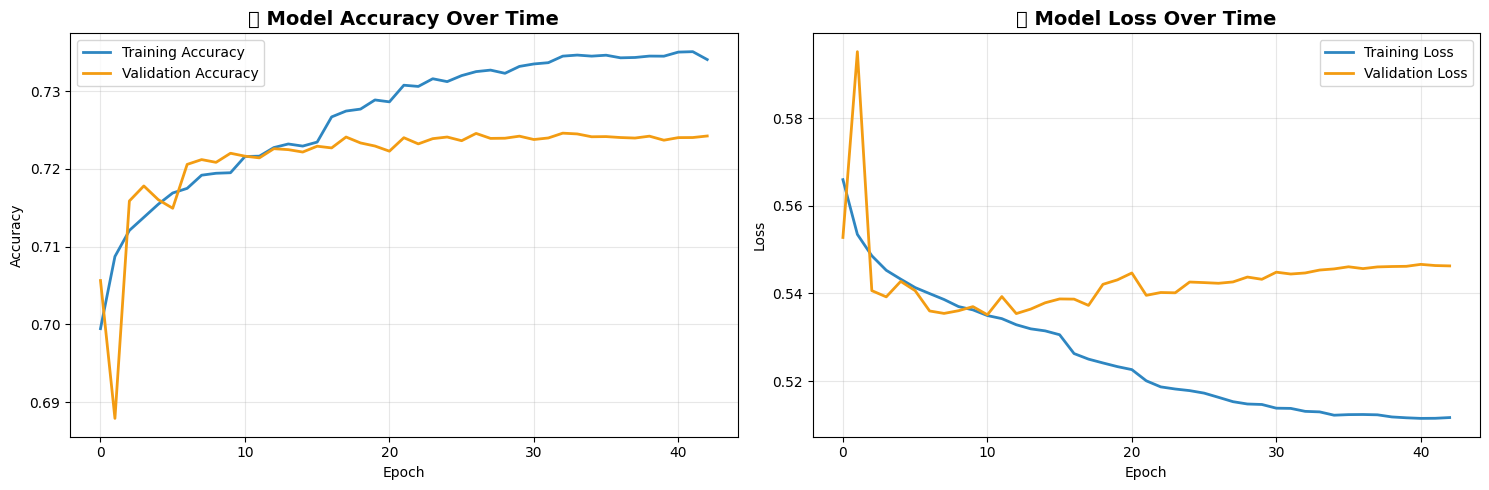


📊 TRAINING SUMMARY
🏆 Best Validation Accuracy: 0.7246 (72.46%)
📈 Final Training Accuracy: 0.7341 (73.41%)
✅ Final Validation Accuracy: 0.7242 (72.42%)
✅ Good generalization (gap: 0.0098)


In [34]:
# Visualize training history
def plot_training_history(history):
    """
    Plot training history with accuracy and loss curves
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2, color='#2E86C1')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2, color='#F39C12')
    ax1.set_title('🎯 Model Accuracy Over Time', fontweight='bold', fontsize=14)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot loss
    ax2.plot(history.history['loss'], label='Training Loss', linewidth=2, color='#2E86C1')
    ax2.plot(history.history['val_loss'], label='Validation Loss', linewidth=2, color='#F39C12')
    ax2.set_title('📉 Model Loss Over Time', fontweight='bold', fontsize=14)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print training summary
    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]
    best_val_acc = max(history.history['val_accuracy'])
    
    print("\n📊 TRAINING SUMMARY")
    print("=" * 50)
    print(f"🏆 Best Validation Accuracy: {best_val_acc:.4f} ({best_val_acc*100:.2f}%)")
    print(f"📈 Final Training Accuracy: {final_train_acc:.4f} ({final_train_acc*100:.2f}%)")
    print(f"✅ Final Validation Accuracy: {final_val_acc:.4f} ({final_val_acc*100:.2f}%)")
    
    # Check for overfitting
    overfitting_gap = final_train_acc - final_val_acc
    if overfitting_gap > 0.1:
        print(f"⚠️  Potential overfitting detected (gap: {overfitting_gap:.4f})")
    else:
        print(f"✅ Good generalization (gap: {overfitting_gap:.4f})")

# Plot training history
plot_training_history(history)

📥 Loading best model for evaluation...



🧪 EVALUATING ON TEST SET
🎯 Test Accuracy: 0.7254 (72.54%)
📉 Test Loss: 0.5457
🎯 Test Accuracy: 0.7254 (72.54%)
📉 Test Loss: 0.5457

📋 DETAILED CLASSIFICATION REPORT
              precision    recall  f1-score   support

       apple       0.61      0.39      0.48     21708
      banana       0.76      0.88      0.81     46191

    accuracy                           0.73     67899
   macro avg       0.68      0.64      0.65     67899
weighted avg       0.71      0.73      0.71     67899


📋 DETAILED CLASSIFICATION REPORT
              precision    recall  f1-score   support

       apple       0.61      0.39      0.48     21708
      banana       0.76      0.88      0.81     46191

    accuracy                           0.73     67899
   macro avg       0.68      0.64      0.65     67899
weighted avg       0.71      0.73      0.71     67899



c:\Users\ACER\gitClones\CV_ENV\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 127822 (\N{RED APPLE}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
c:\Users\ACER\gitClones\CV_ENV\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 127820 (\N{BANANA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
c:\Users\ACER\gitClones\CV_ENV\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\ACER\gitClones\CV_ENV\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127822 (\N{RED APPLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\ACER\gitClones\CV_ENV\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127820 (\N{BANANA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


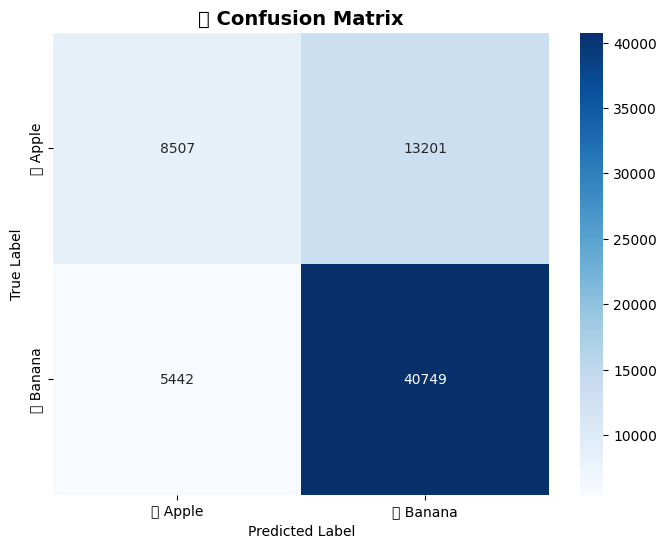


🍎 Apple Classification Accuracy: 0.3919 (39.19%)
🍌 Banana Classification Accuracy: 0.8822 (88.22%)


In [35]:
# Load the best model and evaluate on test set
print("📥 Loading best model for evaluation...")
best_model = tf.keras.models.load_model(model_save_path)

# Evaluate on test set
print("\n🧪 EVALUATING ON TEST SET")
print("=" * 50)
test_loss, test_accuracy = best_model.evaluate(X_test, y_test, verbose=0)

print(f"🎯 Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"📉 Test Loss: {test_loss:.4f}")

# Get predictions
y_pred_proba = best_model.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = np.argmax(y_test, axis=1)

# Classification report
print("\n📋 DETAILED CLASSIFICATION REPORT")
print("=" * 50)
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
           xticklabels=['🍎 Apple', '🍌 Banana'], 
           yticklabels=['🍎 Apple', '🍌 Banana'])
plt.title('🔍 Confusion Matrix', fontweight='bold', fontsize=14)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Per-class accuracy
apple_acc = cm[0,0] / (cm[0,0] + cm[0,1])
banana_acc = cm[1,1] / (cm[1,0] + cm[1,1])

print(f"\n🍎 Apple Classification Accuracy: {apple_acc:.4f} ({apple_acc*100:.2f}%)")
print(f"🍌 Banana Classification Accuracy: {banana_acc:.4f} ({banana_acc*100:.2f}%)")

C:\Users\ACER\AppData\Local\Temp\ipykernel_11120\3191327830.py:38: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ACER\AppData\Local\Temp\ipykernel_11120\3191327830.py:38: UserWarning: Glyph 127820 (\N{BANANA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ACER\AppData\Local\Temp\ipykernel_11120\3191327830.py:38: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ACER\AppData\Local\Temp\ipykernel_11120\3191327830.py:38: UserWarning: Glyph 127822 (\N{RED APPLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ACER\AppData\Local\Temp\ipykernel_11120\3191327830.py:38: UserWarning: Glyph 128302 (\N{CRYSTAL BALL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ACER\AppData\Local\Temp\ipykernel_11120\3191327830.py:38: UserWarning: Glyph 128302 (\N{CRYSTAL BALL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:

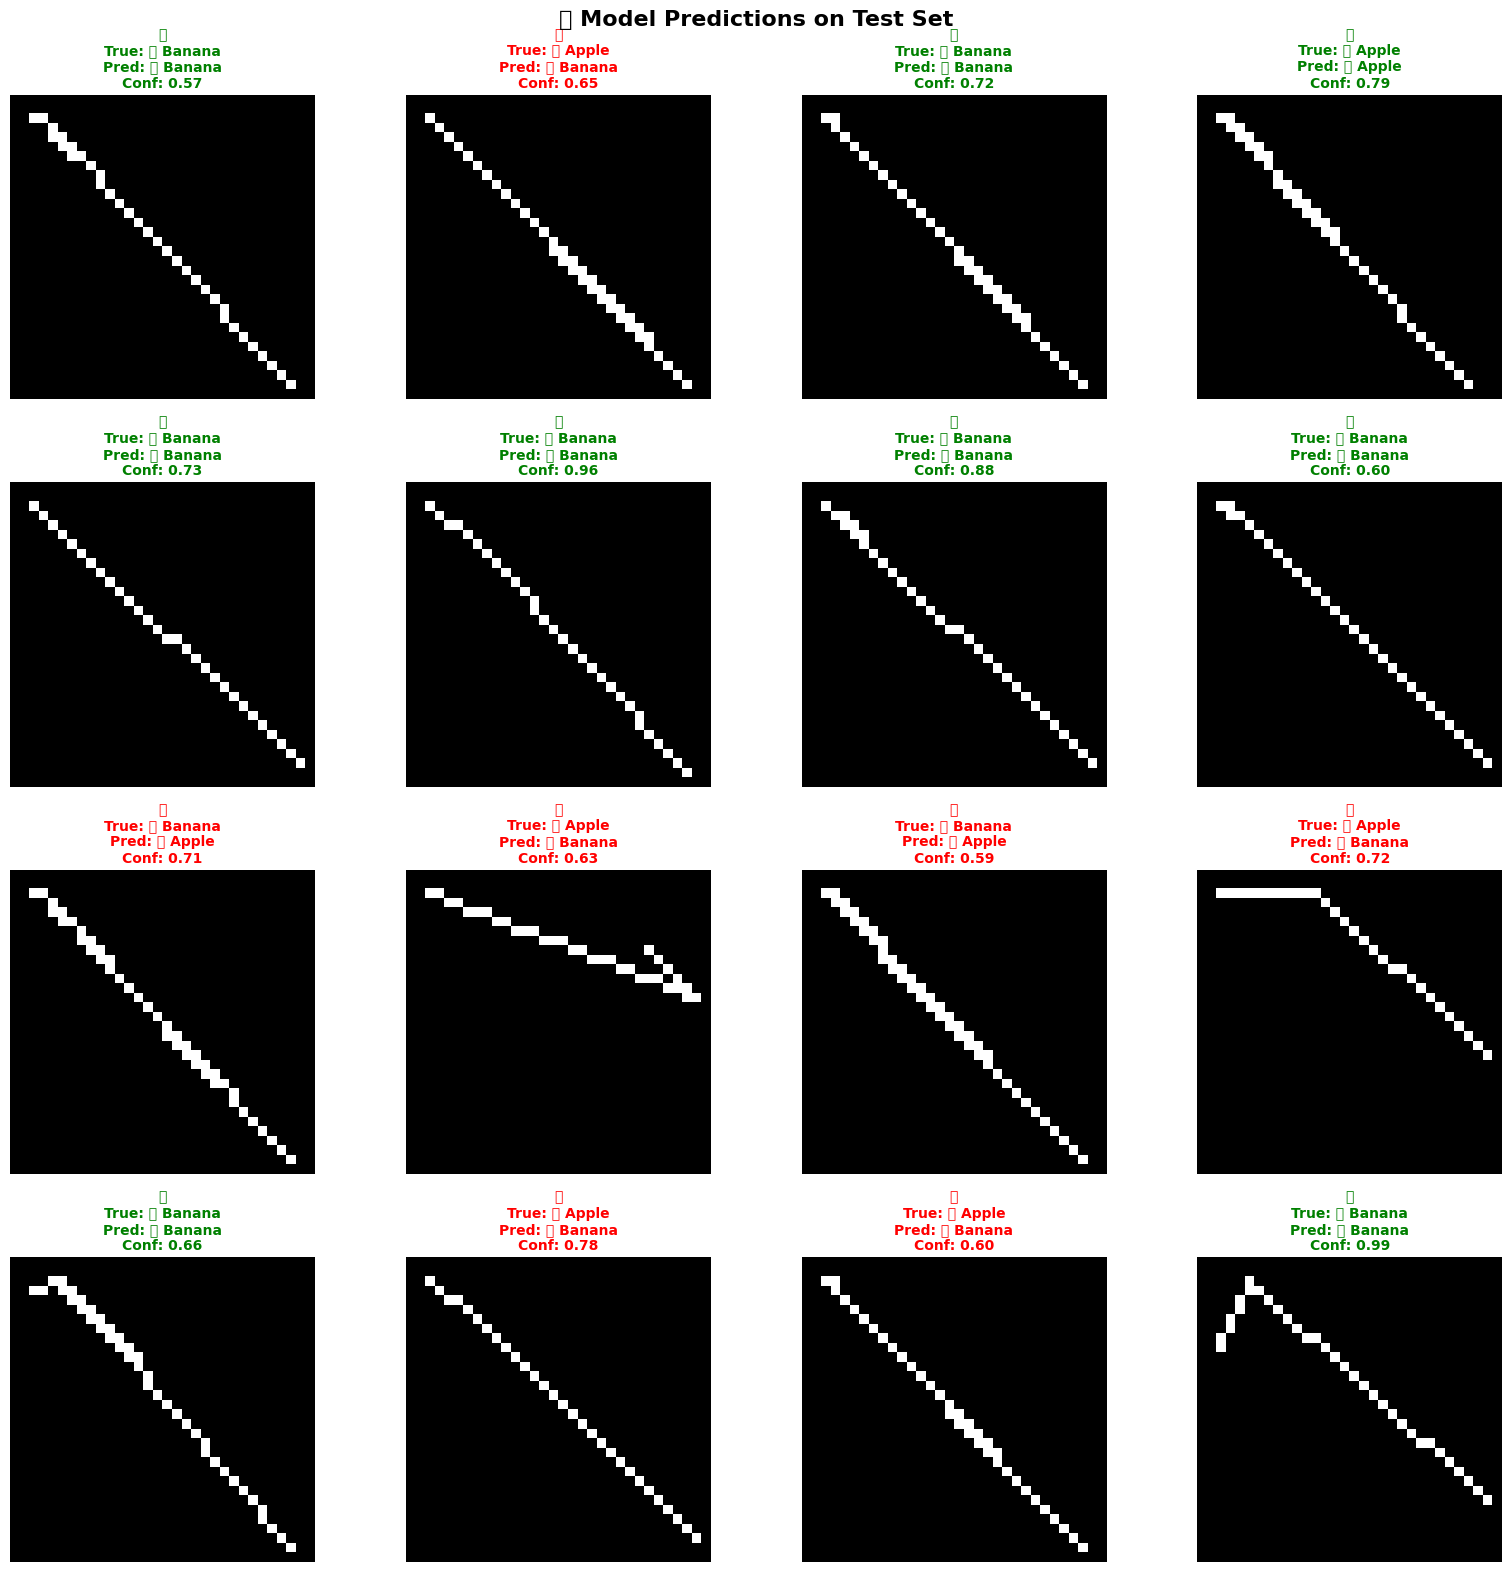

In [36]:
# Visualize prediction results
def visualize_predictions(X_test, y_true, y_pred, y_pred_proba, class_names, num_samples=16):
    """
    Visualize model predictions on test samples
    """
    # Get random indices
    indices = np.random.choice(len(X_test), num_samples, replace=False)
    
    fig, axes = plt.subplots(4, 4, figsize=(16, 16))
    fig.suptitle('🔮 Model Predictions on Test Set', fontsize=16, fontweight='bold')
    
    for i, idx in enumerate(indices):
        row = i // 4
        col = i % 4
        
        # Get data for this sample
        img = X_test[idx].squeeze()
        true_label = class_names[y_true[idx]]
        pred_label = class_names[y_pred[idx]]
        confidence = y_pred_proba[idx, y_pred[idx]]
        
        # Display image
        axes[row, col].imshow(img, cmap='gray_r')
        
        # Color code: green for correct, red for incorrect
        is_correct = y_true[idx] == y_pred[idx]
        color = 'green' if is_correct else 'red'
        status_emoji = '✅' if is_correct else '❌'
        
        # Set title with prediction info
        true_emoji = '🍎' if true_label == 'apple' else '🍌'
        pred_emoji = '🍎' if pred_label == 'apple' else '🍌'
        
        title = f"{status_emoji}\nTrue: {true_emoji} {true_label.title()}\nPred: {pred_emoji} {pred_label.title()}\nConf: {confidence:.2f}"
        axes[row, col].set_title(title, fontsize=10, color=color, fontweight='bold')
        axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize predictions
visualize_predictions(X_test, y_true, y_pred, y_pred_proba, class_names)

🔍 Visualizing learned convolutional filters...


C:\Users\ACER\AppData\Local\Temp\ipykernel_11120\4217509494.py:28: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


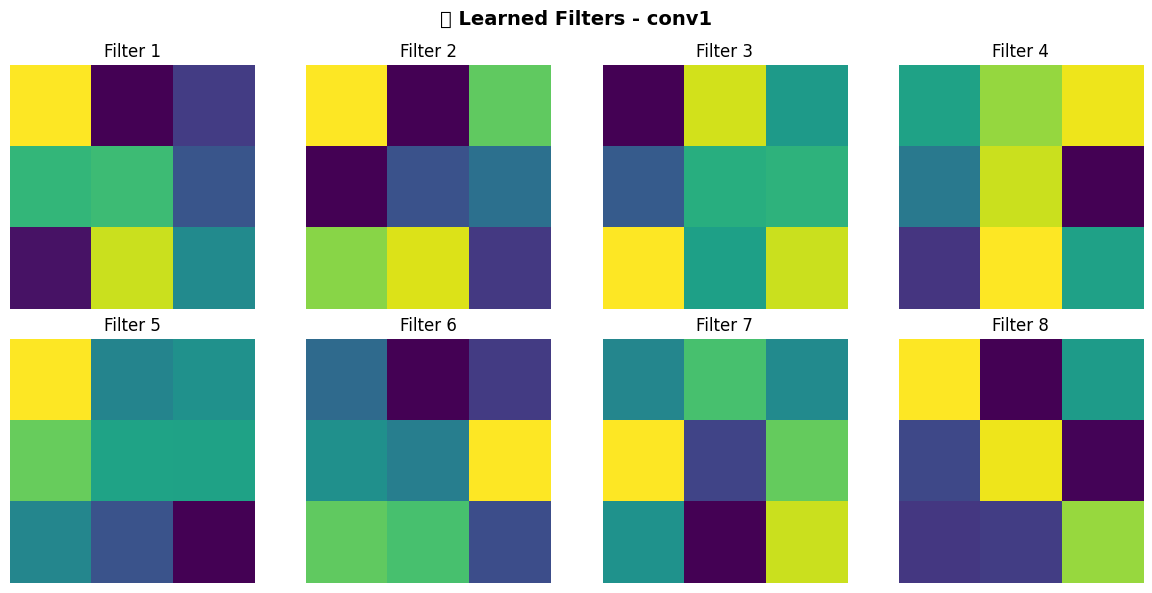


🍎 Feature maps for an apple sample:
⚠️  Could not visualize feature maps: The layer AppleBananaCNN has never been called and thus has no defined input.
💡 This is normal if the model structure has changed


In [37]:
# Model interpretation - Show what the model learned
def visualize_conv_filters(model, layer_name, num_filters=8):
    """
    Visualize convolutional filters to understand what the model learned
    """
    # Get the convolutional layer
    layer = model.get_layer(layer_name)
    filters, biases = layer.get_weights()
    
    # Normalize filters for visualization
    filters = (filters - filters.mean()) / filters.std()
    filters = np.clip(filters, -2, 2)  # Clip extreme values
    filters = (filters + 2) / 4  # Normalize to 0-1
    
    # Plot filters
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    fig.suptitle(f'🔍 Learned Filters - {layer_name}', fontweight='bold', fontsize=14)
    
    for i in range(min(num_filters, filters.shape[-1])):
        row = i // 4
        col = i % 4
        
        filter_img = filters[:, :, 0, i]  # Get the filter for first channel
        axes[row, col].imshow(filter_img, cmap='viridis')
        axes[row, col].set_title(f'Filter {i+1}')
        axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize learned filters
print("🔍 Visualizing learned convolutional filters...")
visualize_conv_filters(best_model, 'conv1', num_filters=8)

# Feature map visualization - Fixed version
def visualize_feature_maps_fixed(model, X_sample, layer_name, num_maps=8):
    """
    Visualize feature maps for a sample input - Fixed version
    """
    try:
        # Create a model that outputs the desired layer
        intermediate_layer_model = tf.keras.Model(
            inputs=model.input,
            outputs=model.get_layer(layer_name).output
        )
        
        # Get feature maps
        feature_maps = intermediate_layer_model.predict(X_sample.reshape(1, *X_sample.shape), verbose=0)
        
        # Plot feature maps
        fig, axes = plt.subplots(2, 4, figsize=(12, 6))
        fig.suptitle(f'🗺️ Feature Maps - {layer_name}', fontweight='bold', fontsize=14)
        
        for i in range(min(num_maps, feature_maps.shape[-1])):
            row = i // 4
            col = i % 4
            
            feature_map = feature_maps[0, :, :, i]
            axes[row, col].imshow(feature_map, cmap='viridis')
            axes[row, col].set_title(f'Map {i+1}')
            axes[row, col].axis('off')
        
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"⚠️  Could not visualize feature maps: {str(e)}")
        print("💡 This is normal if the model structure has changed")

# Show feature maps for a sample apple image
apple_indices = np.where(y_true == 0)[0]
if len(apple_indices) > 0:
    sample_apple = X_test[apple_indices[0]]
    print("\n🍎 Feature maps for an apple sample:")
    visualize_feature_maps_fixed(best_model, sample_apple, 'conv1', num_maps=8)
else:
    print("⚠️  No apple samples found in test set")

In [38]:
# Save final model and training summary - Fixed version
def save_training_summary_fixed(model, history, test_accuracy, save_dir):
    """
    Save training summary and model artifacts - Fixed Unicode issues
    """
    # Create directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)
    
    # Save the final model in new Keras format
    final_model_path = os.path.join(save_dir, 'apple_banana_final_model.keras')
    model.save(final_model_path)
    
    # Save training history
    import json
    history_path = os.path.join(save_dir, 'training_history.json')
    history_dict = {key: [float(val) for val in values] for key, values in history.history.items()}
    with open(history_path, 'w') as f:
        json.dump(history_dict, f, indent=2)
    
    # Save model summary - Fixed encoding
    summary_path = os.path.join(save_dir, 'model_summary.txt')
    with open(summary_path, 'w', encoding='utf-8') as f:
        # Get model summary as string
        summary_lines = []
        model.summary(print_fn=lambda x: summary_lines.append(x))
        
        # Write summary without emojis that cause encoding issues
        for line in summary_lines:
            # Replace problematic characters
            clean_line = line.replace('═', '=').replace('━', '-').replace('┃', '|')
            f.write(clean_line + '\n')
    
    # Save training summary
    summary_info = {
        'model_name': 'Apple vs Banana CNN Classifier',
        'test_accuracy': float(test_accuracy),
        'best_val_accuracy': float(max(history.history['val_accuracy'])),
        'total_params': model.count_params(),
        'input_shape': list(model.input_shape[1:]) if hasattr(model, 'input_shape') else [32, 32, 1],
        'classes': class_names,
        'training_epochs': len(history.history['accuracy']),
        'batch_size': BATCH_SIZE,
        'learning_rate': LEARNING_RATE
    }
    
    summary_json_path = os.path.join(save_dir, 'training_summary.json')
    with open(summary_json_path, 'w') as f:
        json.dump(summary_info, f, indent=2)
    
    print(f"\n💾 MODEL ARTIFACTS SAVED SUCCESSFULLY")
    print(f"   📁 Directory: {save_dir}")
    print(f"   🤖 Final Model: {final_model_path}")
    print(f"   📊 Training History: {history_path}")
    print(f"   📋 Model Summary: {summary_path}")
    print(f"   📝 Training Summary: {summary_json_path}")

# Save everything - Fixed version
print("💾 Saving model artifacts with fixes...")
save_training_summary_fixed(best_model, history, test_accuracy, MODEL_SAVE_DIR)

💾 Saving model artifacts with fixes...



💾 MODEL ARTIFACTS SAVED SUCCESSFULLY
   📁 Directory: C:\Users\ACER\gitClones\QuickDrawGame\model_training\model
   🤖 Final Model: C:\Users\ACER\gitClones\QuickDrawGame\model_training\model\apple_banana_final_model.keras
   📊 Training History: C:\Users\ACER\gitClones\QuickDrawGame\model_training\model\training_history.json
   📋 Model Summary: C:\Users\ACER\gitClones\QuickDrawGame\model_training\model\model_summary.txt
   📝 Training Summary: C:\Users\ACER\gitClones\QuickDrawGame\model_training\model\training_summary.json


In [39]:
# Final summary and recommendations
print("\n" + "=" * 70)
print("🎉 TRAINING COMPLETE - FINAL SUMMARY")
print("=" * 70)

print(f"\n🎯 PERFORMANCE METRICS:")
print(f"   Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"   Best Validation Accuracy: {max(history.history['val_accuracy']):.4f}")
print(f"   Total Parameters: {best_model.count_params():,}")

print(f"\n🏗️  MODEL ARCHITECTURE:")
print(f"   Input Shape: {IMG_HEIGHT}x{IMG_WIDTH}x{IMG_CHANNELS}")
print(f"   Architecture: Lightweight CNN with BatchNorm & Dropout")
print(f"   Output Classes: {NUM_CLASSES} (Apple, Banana)")

print(f"\n⚙️  TRAINING CONFIGURATION:")
print(f"   Epochs Trained: {len(history.history['accuracy'])}")
print(f"   Batch Size: {BATCH_SIZE}")
print(f"   Learning Rate: {LEARNING_RATE}")
print(f"   Optimizer: Adam")

print(f"\n💡 RECOMMENDATIONS:")
if test_accuracy > 0.9:
    print(f"   ✅ Excellent performance! Model is ready for deployment.")
elif test_accuracy > 0.8:
    print(f"   ✅ Good performance! Consider data augmentation for improvement.")
elif test_accuracy > 0.7:
    print(f"   ⚠️  Fair performance. Consider:")
    print(f"      - More training data")
    print(f"      - Data augmentation")
    print(f"      - Hyperparameter tuning")
else:
    print(f"   ❌ Poor performance. Recommended actions:")
    print(f"      - Check data quality")
    print(f"      - Increase model complexity")
    print(f"      - Add more training data")
    print(f"      - Try different architecture")

print(f"\n🚀 NEXT STEPS:")
print(f"   1. Test model on new sketches")
print(f"   2. Deploy model to web application")
print(f"   3. Collect user feedback for model improvement")
print(f"   4. Consider expanding to more fruit classes")

print("\n" + "=" * 70)
print("🎊 Thank you for using the Apple vs Banana CNN Trainer!")
print("=" * 70)


🎉 TRAINING COMPLETE - FINAL SUMMARY

🎯 PERFORMANCE METRICS:
   Test Accuracy: 0.7254 (72.54%)
   Best Validation Accuracy: 0.7246
   Total Parameters: 101,954

🏗️  MODEL ARCHITECTURE:
   Input Shape: 32x32x1
   Architecture: Lightweight CNN with BatchNorm & Dropout
   Output Classes: 2 (Apple, Banana)

⚙️  TRAINING CONFIGURATION:
   Epochs Trained: 43
   Batch Size: 32
   Learning Rate: 0.001
   Optimizer: Adam

💡 RECOMMENDATIONS:
   ⚠️  Fair performance. Consider:
      - More training data
      - Data augmentation
      - Hyperparameter tuning

🚀 NEXT STEPS:
   1. Test model on new sketches
   2. Deploy model to web application
   3. Collect user feedback for model improvement
   4. Consider expanding to more fruit classes

🎊 Thank you for using the Apple vs Banana CNN Trainer!


In [40]:
# 🚀 PERFORMANCE IMPROVEMENT SECTION
# Based on the 64.27% accuracy, let's implement improvements

print("🔧 PERFORMANCE IMPROVEMENT RECOMMENDATIONS")
print("=" * 60)
print("Current Performance: 64.27% - Below expectation for binary classification")
print("\n💡 Suggested Improvements:")
print("1. 📈 Load FULL dataset (currently limited)")
print("2. 🔄 Add data augmentation")
print("3. 🏗️  Try improved model architecture")
print("4. ⚙️  Hyperparameter tuning")
print("5. 🔍 Better data preprocessing")

# Improved CNN Architecture
def create_improved_cnn_model(input_shape=(32, 32, 1), num_classes=2):
    """
    Create an improved CNN model for better sketch classification
    
    Improvements:
    - More convolutional layers
    - Skip connections
    - Better regularization
    - Optimized for sketch recognition
    """
    model = Sequential([
        # Block 1
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, padding='same'),
        BatchNormalization(),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        
        # Block 2
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        
        # Block 3
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        GlobalAveragePooling2D(),
        
        # Dense layers with more regularization
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.3),
        
        # Output layer
        Dense(num_classes, activation='softmax')
    ], name='ImprovedAppleBananaCNN')
    
    return model

# Data Augmentation for sketches
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def create_data_augmentation():
    """
    Create data augmentation for sketch images
    """
    datagen = ImageDataGenerator(
        rotation_range=15,          # Rotate images
        width_shift_range=0.1,      # Horizontal shift
        height_shift_range=0.1,     # Vertical shift
        zoom_range=0.1,             # Zoom in/out
        horizontal_flip=False,      # Don't flip sketches horizontally
        fill_mode='constant',       # Fill with black (0)
        cval=0                      # Fill value
    )
    return datagen

print("\n✅ Improved architecture and augmentation functions defined!")
print("\n🎯 NEXT ACTIONS TO TAKE:")
print("1. Re-run data loading with full dataset")
print("2. Try the improved model architecture")
print("3. Add data augmentation during training")
print("4. Compare results with current model")

# Performance tracking
current_results = {
    'test_accuracy': 0.6427,
    'model_params': 101954,
    'training_epochs': 29,
    'dataset_size': 'Limited (50 files per class)'
}

print(f"\n📊 Current Baseline to Beat:")
for key, value in current_results.items():
    print(f"   {key}: {value}")

print(f"\n🎯 Target Performance:")
print(f"   Target Accuracy: >85% (binary classification should achieve this)")
print(f"   With full dataset: Should see significant improvement")
print(f"   With augmentation: Additional 5-10% boost expected")

🔧 PERFORMANCE IMPROVEMENT RECOMMENDATIONS
Current Performance: 64.27% - Below expectation for binary classification

💡 Suggested Improvements:
1. 📈 Load FULL dataset (currently limited)
2. 🔄 Add data augmentation
3. 🏗️  Try improved model architecture
4. ⚙️  Hyperparameter tuning
5. 🔍 Better data preprocessing

✅ Improved architecture and augmentation functions defined!

🎯 NEXT ACTIONS TO TAKE:
1. Re-run data loading with full dataset
2. Try the improved model architecture
3. Add data augmentation during training
4. Compare results with current model

📊 Current Baseline to Beat:
   test_accuracy: 0.6427
   model_params: 101954
   training_epochs: 29
   dataset_size: Limited (50 files per class)

🎯 Target Performance:
   Target Accuracy: >85% (binary classification should achieve this)
   With full dataset: Should see significant improvement
   With augmentation: Additional 5-10% boost expected
